In [13]:
# model evaluation

# Basis
# -----
# Pipeline
# hold-out, K-fold, leave-one
# score


# load new dataset
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
print(df.head())

# classify label and feature
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

# encode the string label to numerical label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(pd.DataFrame(y).head())

# split dataset into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

         0  1      2      3       4       5        6        7       8   \
0    842302  M  17.99  10.38  122.80  1001.0  0.11840  0.27760  0.3001   
1    842517  M  20.57  17.77  132.90  1326.0  0.08474  0.07864  0.0869   
2  84300903  M  19.69  21.25  130.00  1203.0  0.10960  0.15990  0.1974   
3  84348301  M  11.42  20.38   77.58   386.1  0.14250  0.28390  0.2414   
4  84358402  M  20.29  14.34  135.10  1297.0  0.10030  0.13280  0.1980   

        9   ...     22     23      24      25      26      27      28      29  \
0  0.14710  ...  25.38  17.33  184.60  2019.0  0.1622  0.6656  0.7119  0.2654   
1  0.07017  ...  24.99  23.41  158.80  1956.0  0.1238  0.1866  0.2416  0.1860   
2  0.12790  ...  23.57  25.53  152.50  1709.0  0.1444  0.4245  0.4504  0.2430   
3  0.10520  ...  14.91  26.50   98.87   567.7  0.2098  0.8663  0.6869  0.2575   
4  0.10430  ...  22.54  16.67  152.20  1575.0  0.1374  0.2050  0.4000  0.1625   

       30       31  
0  0.4601  0.11890  
1  0.2750  0.08902  
2  0.

In [14]:
# build up pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_LR = make_pipeline(StandardScaler(), PCA(n_components=2), 
                        LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs'))

# use pipeline to simply fit, transform and predict
pipe_LR.fit(X_train, y_train)
print(f"{pipe_LR.score(X_test, y_test)}")

0.956140350877193


In [15]:
# introduce K-fold cross-validation
import numpy as np
from sklearn.model_selection import StratifiedKFold

SKF = StratifiedKFold(n_splits=10)
kfold = SKF.split(X_train, y_train)

# evaluate model
scores = []
for k, (train, valid) in enumerate(kfold):
    pipe_LR.fit(X_train[train], y_train[train])
    score = pipe_LR.score(X_train[valid], y_train[valid])
    scores.append(score)
    print(f"Flod: {k+1}, Data ratio: {np.bincount(y_train[train])}, Accuracy: {score}")
print(f"\nMean Accuracy: {np.mean(scores)} +/- {np.std(scores)}")

Flod: 1, Data ratio: [256 153], Accuracy: 0.9347826086956522
Flod: 2, Data ratio: [256 153], Accuracy: 0.9347826086956522
Flod: 3, Data ratio: [256 153], Accuracy: 0.9565217391304348
Flod: 4, Data ratio: [256 153], Accuracy: 0.9565217391304348
Flod: 5, Data ratio: [256 153], Accuracy: 0.9347826086956522
Flod: 6, Data ratio: [257 153], Accuracy: 0.9555555555555556
Flod: 7, Data ratio: [257 153], Accuracy: 0.9777777777777777
Flod: 8, Data ratio: [257 153], Accuracy: 0.9333333333333333
Flod: 9, Data ratio: [257 153], Accuracy: 0.9555555555555556
Flod: 10, Data ratio: [257 153], Accuracy: 0.9555555555555556

Mean Accuracy: 0.9495169082125603 +/- 0.013854294239660376


In [16]:
# a more convenient way of score and evaluate
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_LR, 
                         X=X_train, 
                         y=y_train, 
                         cv=10, 
                         n_jobs=2)        # n-jobs = transaction or thread, meaning how many cores are used for computation
print(f"Mean Accuracy: {np.mean(scores)} +/- {np.std(scores)}")

Mean Accuracy: 0.9495169082125603 +/- 0.013854294239660376


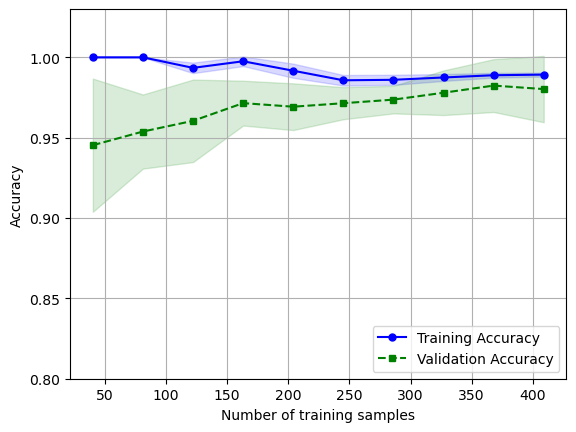

In [17]:
# Learning Curve
# --------------
# x: samples number, y: accuracy
# function: to see how model accuracy change with samples number growing

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', 
                                                             random_state=1, 
                                                             solver='lbfgs', 
                                                             max_iter=10000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train, 
                                                        y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=10, 
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, 
                 train_mean+train_std, 
                 train_mean-train_std, 
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, 
         color='green', marker='s', 
         markersize=5, linestyle='--', 
         label='Validation Accuracy')
plt.fill_between(train_sizes, 
                 test_mean+test_std, 
                 test_mean-test_std, 
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

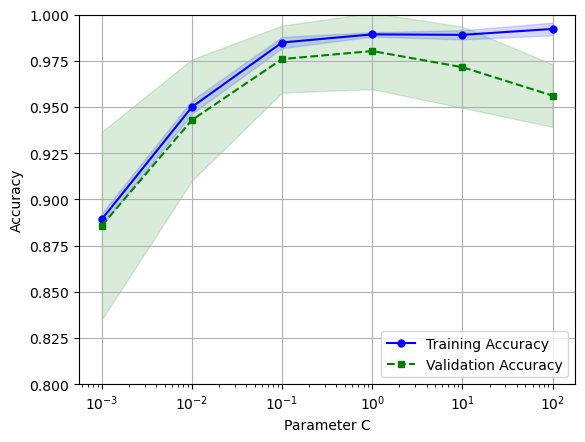

In [18]:
# validation curve
# ----------------
# x: parameters, y: accuracy
# function: to see how accuracy change with parameters growing

from sklearn.model_selection import validation_curve

parameter_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, 
                                             X=X_train, 
                                             y=y_train, 
                                             param_name='logisticregression__C', 
                                             param_range=parameter_range, 
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(parameter_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training Accuracy')
plt.fill_between(parameter_range, 
                 train_mean+train_std, 
                 train_mean-train_std, 
                 alpha=0.15, color='blue')

plt.plot(parameter_range, test_mean, 
         color='green', marker='s', 
         markersize=5, linestyle='--', 
         label='Validation Accuracy')
plt.fill_between(parameter_range, 
                 test_mean+test_std, 
                 test_mean-test_std, 
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()